In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn


import torch.optim as optim

import sys
sys.path.insert(0, '../libraries/')

import mnist_data_lib
import mnist_vae_lib
import common_utils

# Load data

In [2]:
train_set, test_set = mnist_data_lib.load_mnist_data()

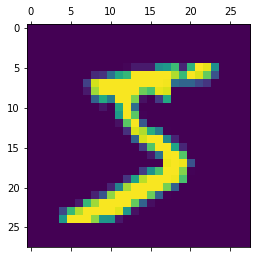

In [3]:
plt.matshow(train_set.train_data[0])

In [4]:
slen = train_set.train_data[0].shape[0]

# Get data loaders

In [5]:
batchsize = 20

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batchsize,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batchsize,
                shuffle=False)


In [6]:
for batch_idx, d in enumerate(train_loader):
    data = d
    break

# Define VAE

In [7]:
latent_dim = 5
n_classes = 10

In [8]:
vae = mnist_vae_lib.HandwritingVAE(latent_dim = latent_dim, 
                                    n_classes = n_classes)

In [9]:
print(vae.parameters)

<bound method Module.parameters of HandwritingVAE(
  (encoder): MLPEncoder(
    (fc1): Linear(in_features=784, out_features=500, bias=True)
    (fc2): Linear(in_features=500, out_features=784, bias=True)
    (fc3): Linear(in_features=784, out_features=19, bias=True)
  )
  (decoder): MLPConditionalDecoder(
    (fc1): Linear(in_features=15, out_features=784, bias=True)
    (fc2): Linear(in_features=784, out_features=500, bias=True)
    (fc3): Linear(in_features=500, out_features=1568, bias=True)
  )
)>


In [10]:
28 * 28

784

In [11]:
2 * 28 * 28

1568

In [12]:
### Check things run

In [13]:
# check encoder 

latent_means, latent_std, free_class_weights = \
    vae.encoder(data[0])
    
assert latent_means.shape[0] == batchsize
assert latent_means.shape[1] == latent_dim

assert latent_std.shape[0] == batchsize
assert latent_std.shape[1] == latent_dim

assert free_class_weights.shape[0] == batchsize
assert free_class_weights.shape[1] == n_classes 


In [14]:
z_ind = torch.argmax(free_class_weights, dim = 1)

In [15]:
z_ind

tensor([ 7,  2,  5,  7,  7,  7,  5,  7,  7,  7,  7,  5,  7,  7,
         7,  7,  5,  7,  5,  5])

In [16]:
# check one hot encoding 

one_hot_z = common_utils.get_one_hot_encoding_from_int(z_ind, 10)

seq = torch.Tensor([i for i in range(n_classes)])

for n in range(batchsize): 
    foo = one_hot_z[n, :]
    
    assert foo[z_ind[n]] == 1.
    assert sum(foo) == 1.

In [17]:
image_mean, image_std = vae.decoder(latent_means, one_hot_z)
assert image_mean.shape[0] == batchsize
assert image_mean.shape[1] == slen
assert image_mean.shape[1] == slen

In [18]:
# check loss goes through

In [19]:
vae.loss(data[0])

tensor(16282.3174)

# Check gradient works 

In [20]:
def get_vae_params(vae): 
    vae_params = np.array([])
    for f in vae.parameters(): 
        vae_params = np.append(vae_params, f.detach().numpy().flatten())
    return vae_params


In [21]:
vae_params0 = get_vae_params(vae)

In [22]:
assert np.any(np.isnan(vae_params0)) == False

In [23]:
optimizer = optim.Adam(vae.parameters(), lr=0.01)
optimizer.zero_grad()

In [24]:
loss = vae.loss(data[0])
print(loss)

tensor(16278.9551)


In [25]:
loss.backward()
optimizer.step()

In [26]:
vae_params1 = get_vae_params(vae)

In [27]:
assert np.any(np.isnan(vae_params1)) == False

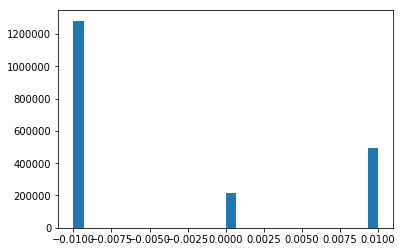

In [28]:
plt.hist(vae_params1 - vae_params0, bins = 30); 

In [29]:
loss = vae.loss(data[0])

In [30]:
assert np.isfinite(loss.detach().numpy())

# Test training

In [31]:
from torch.utils.data.sampler import Sampler

In [32]:
trainloader_subs = mnist_data_lib.subsample_mnist_data(batch_size=10, 
                                                       data_set=train_set, 
                                                       propn_sample=0.001)

testloader_subs = mnist_data_lib.subsample_mnist_data(batch_size=10, 
                                                       data_set=test_set, 
                                                       propn_sample=0.001)

In [33]:
len(train_loader.dataset)

60000

In [34]:
vae.train_module(trainloader_subs, testloader_subs, 
                 n_epoch = 5, 
                print_every = 2, 
                outfile = './test', 
                set_true_class_label = True)

setting true class label
setting true class label
setting true class label
setting true class label
setting true class label
setting true class label
setting true class label
  * init train recon loss: 4.006862704e+19;
  * init test recon loss: 4.121640723e+19;
setting true class label
setting true class label
setting true class label
setting true class label
setting true class label
setting true class label
[1] loss: 7.708895925e+18  	[0.9 seconds]
setting true class label
setting true class label
setting true class label
setting true class label
setting true class label
setting true class label
[2] loss: 19.74143982  	[0.9 seconds]
setting true class label
setting true class label
setting true class label
setting true class label
setting true class label
setting true class label
setting true class label
  * train recon loss: 5.397624493;
  * test recon loss: 5.561275005;
setting true class label
setting true class label
setting true class label
setting true class label
setting true c

In [35]:
# check reloading

In [36]:
reload_vae = vae = mnist_vae_lib.HandwritingVAE(latent_dim = latent_dim, 
                                    n_classes = n_classes)

In [37]:
enc_file = "./test_enc_final"
dec_file = './test_dec_final'

reload_vae.encoder.load_state_dict(torch.load(enc_file,
                               map_location=lambda storage, loc: storage))

reload_vae.decoder.load_state_dict(torch.load(dec_file,
                               map_location=lambda storage, loc: storage))


In [38]:
reload_vae.eval_vae(trainloader_subs)

tensor(3.8448)